# Data

In [ ]:
# import from google drive
# run this code piece, enter the autorization code
# For mount instructions: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd

from google.colab import drive
drive.mount("/content/drive")

# or import from environment
PROJECT_DIR = "/content/drive/My Drive/Deep Learning System/project"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd $PROJECT_DIR
# !git clone https://github.com/tuanpham96/bnn-cf-vs-robust "$PROJECT_DIR/bnn-cf-vs-robust"

/content/drive/My Drive/Deep Learning System/project


# Generate cifar10 and cifar100 features

In [ ]:
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

import torch
from torchvision import models
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Function
from torch import nn
from torch.utils.data import Dataset

warnings.filterwarnings("ignore")
plt.ion()

In [ ]:
date = datetime.now().strftime('%Y-%m-%d')
path = PROJECT_DIR + '/results_pytorch_memory/' + date
if not (os.path.exists(path)):
    os.makedirs(path)

In [ ]:
class DatasetProcessing(
    Dataset):  # Data must be wrapped on a Dataset parent class where the methods __getitem__ and __len__ must be overrided. Note that,the data is not loaded on memory by now.

    def __init__(self, data, target,
                 transform=None):  # used to initialise the class variables - transform, data, target
        self.transform = transform

        if data.shape[1] == 28:  # in this case data is a mnist like dataset
            self.data = data.astype(np.uint8)[:, :, :, None]  # .reshape((-1,28,28))
        else:  # in this case data is other embedded tasks (cifar, kmnist...)
            self.data = data.astype(np.float32)[:, :, None]
        self.target = torch.from_numpy(target).long()  # needs to be in torch.LongTensor dtype

    def __getitem__(self, index):  # used to retrieve the X and y index value and return it

        if self.transform is not None:
            return self.transform(self.data[index]), self.target[index]
        else:
            return self.data[index], self.target[index]

    def __len__(self):  # returns the length of the data
        return len(list(self.data))


class SignActivation(Function):  # We define a sign activation with derivative equal to clip

    @staticmethod
    def forward(ctx, i):
        result = i.sign()
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i, = ctx.saved_tensors
        grad_i = grad_output.clone()
        grad_i[i.abs() > 1.0] = 0
        return grad_i

Files already downloaded and verified
Files already downloaded and verified


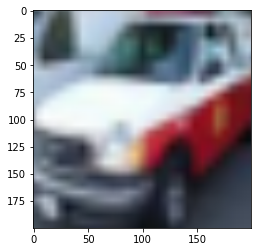

a u t o m o b i l e


In [ ]:
# cifar10
transform_cifar10_train = transforms.Compose(
      [transforms.Resize(220),
        # torchvision.transforms.RandomChoice([torchvision.transforms.RandomRotation(10), torchvision.transforms.RandomCrop((32,32), padding=4, padding_mode = 'edge')]),
        transforms.RandomCrop(200),
        # torchvision.transforms.RandomCrop((32,32), padding=5, padding_mode = 'edge'),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(), transforms.Normalize(mean=(0.0,), std=(1.0,))])

transform_cifar10_test = transforms.Compose(
    [transforms.Resize(220),
      transforms.CenterCrop(200),
      transforms.ToTensor(), transforms.Normalize(mean=(0.0,), std=(1.0,))])

cifar10_train_dset = torchvision.datasets.CIFAR10(f'{PROJECT_DIR}/cifar10_pytorch', train=True,
                                                  transform=transform_cifar10_train, download=True)
cifar10_train_loader = torch.utils.data.DataLoader(cifar10_train_dset, batch_size=500, shuffle=False, num_workers=0)

cifar10_test_dset = torchvision.datasets.CIFAR10(f'{PROJECT_DIR}/cifar10_pytorch', train=False,
                                                  transform=transform_cifar10_test, download=True)
cifar10_test_loader = torch.utils.data.DataLoader(cifar10_test_dset, batch_size=500, shuffle=False, num_workers=0)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(cifar10_train_loader)
images, labels = dataiter.next()
rnd_idx = 60  # np.random.randint(100)

# show images
imshow(torchvision.utils.make_grid(images[rnd_idx], nrow=8))
# print labels
print(' '.join('%5s' % classes[labels[rnd_idx]]))

Files already downloaded and verified
Files already downloaded and verified
10000


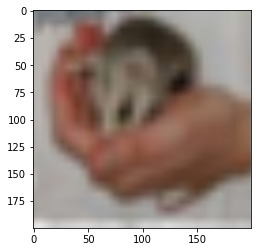

possum


In [ ]:
# cifar100
transform_cifar100_train = transforms.Compose(
    [transforms.Resize(220),
      # torchvision.transforms.RandomChoice([torchvision.transforms.RandomRotation(10), torchvision.transforms.RandomCrop((32,32), padding=4, padding_mode = 'edge')]),
      transforms.RandomCrop(200),
      # torchvision.transforms.RandomCrop((32,32), padding=5, padding_mode = 'edge'),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.ToTensor(), transforms.Normalize(mean=(0.0,), std=(1.0,))])

transform_cifar100_test = transforms.Compose(
    [transforms.Resize(220),
      transforms.CenterCrop(200),
      transforms.ToTensor(), transforms.Normalize(mean=(0.0,), std=(1.0,))])

cifar100_train_dset = torchvision.datasets.CIFAR100(f'{PROJECT_DIR}/cifar100_pytorch', train=True,
                                                    transform=transform_cifar100_train, download=True)
cifar100_train_loader = torch.utils.data.DataLoader(cifar100_train_dset, batch_size=500, shuffle=False,
                                                    num_workers=0)

cifar100_test_dset = torchvision.datasets.CIFAR100(f'{PROJECT_DIR}/cifar100_pytorch', train=False,
                                                    transform=transform_cifar100_test, download=True)
cifar100_test_loader = torch.utils.data.DataLoader(cifar100_test_dset, batch_size=500, shuffle=False, num_workers=0)

pickleFile = open(f"{PROJECT_DIR}/cifar100_pytorch/cifar-100-python/meta", 'rb')
dic = pickle.load(pickleFile)
pickleFile.close()

classes = dic['fine_label_names']

print(len(cifar100_test_dset))


def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(cifar100_train_loader)
images, labels = dataiter.next()
rnd_idx = np.random.randint(100)

# show images
imshow(torchvision.utils.make_grid(images[rnd_idx], nrow=8))
# print labels
print(classes[labels[rnd_idx]])

In [ ]:
%mkdir -p "$PROJECT_DIR/cifar10_features_dataset"
# Extracting features of cifar10 with conv layers of resnet pretrained on imagenet

train_loader = cifar10_train_loader
test_loader = cifar10_test_loader

resnet = models.resnet18(pretrained=True)
resnet_conv = nn.Sequential(*list(resnet.children())[:-1])

for param in resnet_conv.parameters():
    param.requires_grad = False

resnet_conv.cuda()

features_train = []
target_train = []
for i in range(10):
    for idx, (data, target) in enumerate(train_loader):
        data = data.to('cuda')
        target = target.to('cuda')
        features = resnet_conv(data)
        #        print(features.shape)
        features = torch.squeeze(features)
        features_train.append(features)
        target_train.append(target)

features_dset_train = torch.cat(features_train, 0)
target_dset_train = torch.cat(target_train, 0)

features_test = []
target_test = []

for idx, (data, target) in enumerate(test_loader):
    data = data.to('cuda')
    target = target.to('cuda')
    features = resnet_conv(data)
    features = torch.squeeze(features)
    features_test.append(features)
    target_test.append(target)

features_dset_test = torch.cat(features_test, 0)
target_dset_test = torch.cat(target_test, 0)

print(features_dset_train.shape, target_dset_train.shape, features_dset_test.shape, target_dset_test.shape)

torch.save(features_dset_train, f'{PROJECT_DIR}/cifar10_features_dataset/train.pt')
torch.save(target_dset_train, f'{PROJECT_DIR}/cifar10_features_dataset/train_targets.pt')
torch.save(features_dset_test, f'{PROJECT_DIR}/cifar10_features_dataset/test.pt')
torch.save(target_dset_test, f'{PROJECT_DIR}/cifar10_features_dataset/test_targets.pt')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

torch.Size([500000, 512]) torch.Size([500000]) torch.Size([10000, 512]) torch.Size([10000])


In [ ]:
%mkdir -p "$PROJECT_DIR/cifar100_features_dataset"
# Extracting features of cifar100 with conv layers of resnet pretrained on imagenet

train_loader = cifar100_train_loader
test_loader = cifar100_test_loader

resnet = models.resnet18(pretrained=True)
resnet_conv = nn.Sequential(*list(resnet.children())[:-1])

for param in resnet_conv.parameters():
    param.requires_grad = False

resnet_conv.cuda()

features_train = []
target_train = []
for i in range(10):
    for idx, (data, target) in enumerate(train_loader):
        data = data.to('cuda')
        target = target.to('cuda')
        features = resnet_conv(data)
        #        print(features.shape)
        features = torch.squeeze(features)
        features_train.append(features)
        target_train.append(target)

features_dset_train = torch.cat(features_train, 0)
target_dset_train = torch.cat(target_train, 0)

features_test = []
target_test = []

for idx, (data, target) in enumerate(test_loader):
    data = data.to('cuda')
    target = target.to('cuda')
    features = resnet_conv(data)
    features = torch.squeeze(features)
    features_test.append(features)
    target_test.append(target)

features_dset_test = torch.cat(features_test, 0)
target_dset_test = torch.cat(target_test, 0)

print(features_dset_train.shape, target_dset_train.shape, features_dset_test.shape, target_dset_test.shape)

torch.save(features_dset_train, f'{PROJECT_DIR}/cifar100_features_dataset/train.pt')
torch.save(target_dset_train, f'{PROJECT_DIR}/cifar100_features_dataset/train_targets.pt')
torch.save(features_dset_test, f'{PROJECT_DIR}/cifar100_features_dataset/test.pt')
torch.save(target_dset_test, f'{PROJECT_DIR}/cifar100_features_dataset/test_targets.pt')

torch.Size([500000, 512]) torch.Size([500000]) torch.Size([10000, 512]) torch.Size([10000])


# Sequential learning on cifar10 and cifar100

In [ ]:
%cd "$PROJECT_DIR"
%env PYTHONPATH="$PROJECT_DIR/bnn-cf-vs-robust/src"
# !echo $PYTHONPATH

#Fig. 4(e-f)
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 0.0 --epochs-per-task 10 --task-sequence 'vehicles' 'animals'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.0 --epochs-per-task 10 --task-sequence 'vehicles' 'animals'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.3 --epochs-per-task 10 --task-sequence 'vehicles' 'animals'
# #Fig. 4(g-h)
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 0.0 --epochs-per-task 3 --task-sequence 'cifar100-6'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.0 --epochs-per-task 3 --task-sequence 'cifar100-6'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.3 --epochs-per-task 3 --task-sequence 'cifar100-6'

/content/drive/My Drive/Deep Learning System/project
env: PYTHONPATH="/content/drive/My Drive/Deep Learning System/project/bnn-cf-vs-robust/src"
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
BNN(
  (layers): ModuleDict(
    (fc1): BinarizeLinear(in_features=512, out_features=2048, bias=False)
    (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): BinarizeLinear(in_features=2048, out_features=10, bias=False)
    (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
/content/drive/My Drive/Deep Lear

# Plots

In [ ]:
!pip install plotly==5.4.0
!pip install -U kaleido
!pip install path
!pip install --upgrade --user matplotlib 

In [ ]:
import os, glob 
import pandas as pd 
import numpy as np 
import yaml 
from pathlib import Path

import plotly.express as px
import plotly.graph_objects as go

In [ ]:
%cd $PROJECT_DIR
data_root = Path('results/2021-11-29/')
fig_root = Path('figures')
fig_root.mkdir(exist_ok=True, parents=True)

/content/drive/My Drive/Deep Learning System/project


In [ ]:
!ls -latr '$PROJECT_DIR/results/2021-11-29' | grep "^d"

drwx------ 2 root root  4096 Nov 28 01:40 01-40-11_gpu0
drwx------ 2 root root  4096 Nov 28 01:48 01-48-03_gpu0
drwx------ 2 root root  4096 Nov 28 01:55 01-55-49_gpu0
drwx------ 2 root root  4096 Nov 28 02:03 02-03-42_gpu0
drwx------ 2 root root  4096 Nov 28 02:11 02-11-31_gpu0
drwx------ 2 root root  4096 Nov 28 02:19 02-19-16_gpu0
drwx------ 2 root root  4096 Nov 28 02:27 02-27-04_gpu0
drwx------ 2 root root  4096 Nov 28 02:34 02-34-55_gpu0
drwx------ 2 root root  4096 Nov 28 02:42 02-42-37_gpu0
drwx------ 2 root root  4096 Nov 28 02:50 02-50-24_gpu0
drwx------ 2 root root  4096 Nov 28 02:58 02-58-07_gpu0
drwx------ 2 root root  4096 Nov 28 03:05 03-05-50_gpu0
drwx------ 2 root root  4096 Nov 28 03:13 03-13-31_gpu0
drwx------ 2 root root  4096 Nov 28 03:21 03-21-10_gpu0
drwx------ 2 root root  4096 Nov 28 03:28 03-28-48_gpu0
drwx------ 2 root root  4096 Nov 28 03:36 03-36-36_gpu0
drwx------ 2 root root  4096 Nov 28 03:44 03-44-15_gpu0
drwx------ 2 root root  4096 Nov 28 03:52 03-52-

In [ ]:
def load_df(data_root, data_dir, prm_fns = None):
    data_path = data_root / data_dir
    csv_file = glob.glob(str(data_path / '*.csv'))[0]
    prm_file = data_path / 'hyperparameters.txt'
  
    hyp_params = yaml.safe_load(open(prm_file))
    hyp_params = {k:v for list_item in hyp_params for (k,v) in list_item.items()}

    prm2save = {k: fn(hyp_params) for k, fn in prm_fns.items()} if prm_fns else dict()

    df = pd.read_csv(csv_file)\
            .filter(regex='(acc_test_.*|task_order|epoch)', axis=1)\
            .assign(**prm2save)\
            .melt(id_vars=['task_order','epoch'] + list(prm2save.keys()), 
                var_name='test_set', value_name='test_acc')
            
    df['test_set'] = df['test_set'].apply(lambda x: 'task-' + x[-1])

    max_epoch = max(df.epoch)
    df.epoch = (df.task_order - 1) * (max_epoch) + df.epoch 
    return df

def load_dfs(data_root, prm_fns=None, concat=True):
    dirs = [
      # cifar-100
      # '01-22-44_gpu0',
      # '01-30-39_gpu0',
      # '01-38-30_gpu0'
      # cifar-10
      '01-04-46_gpu0',
      '01-10-44_gpu0',
      '01-16-45_gpu0'
    ]
    df = [load_df(data_root, d, prm_fns) 
          for d in os.listdir(data_root) if d in dirs ]
    if concat:
        df = pd.concat(df, ignore_index=True)
    return df

In [ ]:
axis_config = dict(
    showline=True,
    showgrid=False,
    showticklabels=True,
    linecolor='rgb(0, 0, 0)',
    linewidth=2,    
    ticks='outside',
    tickwidth=2
    )

font_config = dict(
    family="Fira Sans",
    size=15,
    color='black'
    )

title_config = dict(
    title_x = 0.5,
    title_y = 0.95,
    title_xanchor = 'center',
    title_yanchor = 'top',
    title_font_size=20
)

general_layout = go.Layout(
    xaxis=axis_config,
    yaxis=axis_config,
    font=font_config,
    margin=dict(autoexpand=True,l=100,r=50,t=100,b=120),
    showlegend=True,
    plot_bgcolor='white',
    autosize=True,
    **title_config
)

for i in range(1,10): # for subplots
    general_layout['xaxis' + str(i)] = axis_config
    general_layout['yaxis' + str(i)] = axis_config

In [ ]:
prm_fns = {
    'meta': lambda hyp_prm: hyp_prm['meta'][0],
    'num_hidden': lambda hyp_prm: hyp_prm['hidden layers'][0]
}

df = load_dfs(data_root, prm_fns)
df = df.loc[df['epoch'] == 20]
meta_0_0 = df.loc[df['meta'] == 0.0]
meta_0_0 = list(meta_0_0.sort_values(by=['test_set'])['test_acc'])
meta_1_0 = df.loc[df['meta'] == 1.0]
meta_1_0 = list(meta_1_0.sort_values(by=['test_set'])['test_acc'])
meta_1_3 = df.loc[df['meta'] == 1.3]
meta_1_3 = list(meta_1_3.sort_values(by=['test_set'])['test_acc'])
df = pd.DataFrame({ 'test_acc': meta_0_0 + meta_1_0 + meta_1_3, 'test_set': [1,2]*3, 'meta': [0.0]*2 + [1.0]*2 + [1.3]*2})

In [ ]:
fig = px.line(
    df, x="test_set", y="test_acc", 
    color="meta",
    # facet_col="meta",
    color_discrete_sequence=px.colors.sequential.Burg,
    facet_col_wrap=7, 
    facet_col_spacing=0.03,
    facet_row_spacing=0.12,
    markers = True
    )

fig.update_traces(line=dict(width=3), marker=dict(size=15))

fig.update_layout(
    general_layout,
    width=800,
    title_y = 0.97,
    height=600,
    font_size = 22, title_font_size = 27,
    title_text='CIFAR-10 features',
    font_family="Calibri",
    # legend=dict(
    #     yanchor="top",
    #     y=0.01,
    #     xanchor="right",
    #     x=0.99
    # )
    xaxis = dict(
      tickmode = 'linear',
      tick0 = 0,
      dtick = 2
  )
)

fig.write_image(fig_root / 'cifar10.svg')

fig.show()